<a href="https://colab.research.google.com/github/jdariasl/ML_2020/blob/master/Labs/lab6/lab6_parte2.ipynb">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [1]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab6
configure_lab6()
from lab6 import *
GRADER, x,y = part_2()

--2020-12-11 12:02:28--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14117 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  13.79K  --.-KB/s    in 0s      

2020-12-11 12:02:29 (98.0 MB/s) - ‘general.py’ saved [14117/14117]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 6 - Parte 2: Reducción de dimensión PCA y LDA

Para el problema de clasificación usaremos la siguiente base de datos: https://archive.ics.uci.edu/ml/datasets/Cardiotocography

Analice la base de datos, sus características, su variable de salida y el contexto del problema.

In [2]:
print('Dimensiones de la base de datos de entrenamiento. dim de X: ' + str(np.shape(x)) + '\tdim de Y: ' + str(np.shape(y)))

Dimensiones de la base de datos de entrenamiento. dim de X: (2126, 22)	dim de Y: (2126,)


Este ejercicio tiene como objetivo implementar varias técnicas de extracción de características (PCA y LDA) y usar RF para resolver un problema de clasificación multietiqueta o multiclase.

**observación para las librerias sklearn **

Llamar explicitamente los parametros de las librerias de sklearn (e.j. si se quiere usar el parametro `kernel` del `SVC`, se debe llamar `SVC(kernel='rbf'`)

En la siguiente celda se define una función para entrenar un SVM para resolver el problema. Esta función la vamos a usar como base para comparar nuestros metodos de selección de características.

In [3]:
def entrenamiento_sin_seleccion_caracteristicas(splits, X, Y):
    """
    Función que ejecuta el entrenamiento del modelo sin una selección particular
    de las características

      Parámetros:splits : numero de particiones  a realizar
      Retorna:
      1. El modelo entreando
      2. El vector de errores
      3. El Intervalo de confianza
      4. El tiempo de procesamiento
    """
    #Implemetamos la metodología de validación
    Errores = np.ones(splits)
    Score = np.ones(splits)
    times = np.ones(splits)
    j = 0
    kf = KFold(n_splits=splits)
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        #Creamos el clasificador SVM.
        clf = SVC(kernel="linear", C=1)
        #Aquí se entran y se valida el modelo sin hacer selección de características
        tiempo_i = time.time()
        clf.fit(X_train,y_train)
        # Validación del modelo
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test))
        times[j] = time.time()-tiempo_i
        j+=1

    return np.mean(Errores), np.std(Errores), np.mean(times)

## Ejercicio 1: Entrenamiento usando PCA para realizar extracción

En este ejercicio vamos a aplicar PCA para realizar la extracción de caracteristicas. Para ello tener en cuenta:

1. Vamos a usar el modulo [PCA de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). El cual ya se encuentra importado (se pueda acceder a el como `PCA(....)`)
2. Tener en cuenta la respuesta de la siguiente pregunta abierta y completar el código de acuerdo a la respuesta usando la libreria y modulo de sklearn correspondiente (El cual tambien deberia ya estar importado en la configuración).
3. Usar 5 particiones en la metodologia de validación
3. Usar la exactitud como medida de error del modulo [metrics de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
4. Vamos a calcular el costo computacional de aplicar la PCA.
5. Recordar que PCA se debe "ajustar" con el conjunto de entrenamiento. Pero la transformación se debe hacer para las particiones de entrenamiento y test.

In [ ]:
#@title Pregunta Abierta
#@markdown ¿Cuando se aplica PCA ¿es necesario estandarizar los datos? Si, No y por qué? En qué consiste dicha estandarización?
respuesta_1 = 'Si es necesario estandarizar los datos, ya que para utilizar el m\xE9todo en su formalidad, se necesita que estos tengan media igual a cero (media=0) y desviaci\xF3n est\xE1ndar igual a uno (desviaci\xF3n est\xE1ndar=1); dicha estandarizaci\xF3n consiste en extraer la media a los datos y dividendo sus variables por la desviaci\xF3n est\xE1ndar respectiva' #@param {type:"string"}

In [ ]:
#@title Pregunta Abierta
#@markdown  La proyección de los datos que realiza PCA busca optimizar una medida, ¿Cuál? Explique.
respuesta_2 = 'La medida que busca optimizar la proyecci\xF3n de PCA es la varianza, o la distancia entre los puntos y su proyecci\xF3n en la recta, ya que lo que se quiere es obtener la estructura de los datos en una dimensi\xF3n mas peque\xF1a, minimizando, u optimizando, su posici\xF3n relativa, de su proyecci\xF3n en dicha dimensi\xF3n' #@param {type:"string"}

In [8]:
#ejercicio de código
from sklearn.decomposition import PCA
def entrenamiento_pca_ext_caracteristicas(n_comp, X, Y):
    """
    Esta función realiza la reducción de la dimensionalidad sobre el conjunto de
    datos de entrenamiento, de acuerdo con las particiones especificadas usando PCA

    Parámetros:
    n_comp, int, Número de componentes para reducción
    n_sets,int, Número de particiones
    X: numpy Array de características
    Y: numpy Array  Vector de etiquetas

    Retorna: 
    ErrorValidacion: El valor medio de errores
    IC_Validacion: Intervalo de confianza
    T_ejec:  El  valor medio del tiempo de ejecución
    """  
    #Implemetamos la metodología de validación 
    Errores = np.ones(5)
    times = np.ones(5)
    j = 0
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ¿es necesario estandarizacion de datos?
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
 
        #dejar el mismo nombre del objeto 
        pca = PCA(n_components=n_comp)
        # para calcular costo computacional
        tiempo_i = time.time()
        # es recomendable usar el metodo que ajusta y transforma
        X_train_pca = pca.fit_transform(X_train, y_train)
        # aca solo usar el metodo de transformar (ya que en el anterior el pca se ajusto)
        X_test_pca = pca.transform(X_test)
        # entrenar el modelo usando las caractieristicas transformadas por PCA
        clf = SVC(kernel="linear", C=1)
        clf.fit(X=X_train_pca, y=y_train)
        tiempo_o = time.time()-tiempo_i
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_pca))
        times[j] = tiempo_o
        j+=1


    return np.mean(Errores), np.std(Errores), np.mean(times)


In [9]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio1", entrenamiento_pca_ext_caracteristicas)

TEST EXITOSO!


## Ejercicio 2 : Experimentar con PCA

Usando las anteriores funciones vamos a realizar experimentos para evaluar la efectividad de PCA, para ello:

1. Utilizar una metodología cross-validation con 5 particiones.
2. Usar como parametros para los experimentos el número de características a extraer
3. Usar la función `entrenamiento_pca_ext_caracteristicas` para realizar la extración de características.
3. Vamos a retornar un DataFrame con las siguientes columnas:
    - CON_SEL (indicando si se uso selección de caracteristicas)
    - NUM_VAR (número de selección de caracteristicas)
    - ERROR_VALIDACION
    - IC_STD_VALIDACION
    - T_EJECUCION: tiempo de ejecucción
4. En la primera fila del dataframe vamos a incluir la evaluación del modelo SVM sin selección de características (usando la función creada en el primer ejercicio). 

In [12]:
#ejercicio de código
def experimentar_PCA(n_feats, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: CON_SEL, NUM_VAR, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    df = pd.DataFrame()
    idx = 0
    split_number = 5
    #Sin selección de características
    error,ic_error,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
    df.loc[idx,'CON_SEL'] = 'NO'
    df.loc[idx,'NUM_VAR'] = X.shape[1] # se usan todas las caracteristicas
    df.loc[idx,'ERROR_VALIDACION'] = error
    df.loc[idx,'IC_STD_VALIDACION'] = ic_error
    df.loc[idx,'T_EJECUCION'] = t_ex
    idx+=1
    print("termina experimento sin selección")
    #Con selección de características
    
    for f in n_feats:
        #Implemetamos la metodología de validación 
        error, ic_error, t_ex = entrenamiento_pca_ext_caracteristicas(n_comp=f, X=X,Y=Y)
        df.loc[idx,'CON_SEL'] = 'SI'
        df.loc[idx,'NUM_VAR'] = X.shape[1]
        df.loc[idx,'ERROR_VALIDACION'] = error
        df.loc[idx, 'IC_STD_VALIDACION'] = ic_error
        df.loc[idx, 'T_EJECUCION'] = t_ex
        idx+=1
    return df


In [13]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio2", experimentar_PCA)

termina experimento sin selección
TEST EXITOSO!


In [14]:
experimentar_PCA(n_feats=[2,5,10,15,20], X= x, Y = y)

termina experimento sin selección


CON_SEL  NUM_VAR  ERROR_VALIDACION  IC_STD_VALIDACION  T_EJECUCION
0      NO     22.0          0.932288           0.042333     0.029769
1      SI     22.0          0.775725           0.143470     0.067112
2      SI     22.0          0.913485           0.055399     0.047418
3      SI     22.0          0.925707           0.050504     0.051187
4      SI     22.0          0.926174           0.039771     0.049234
5      SI     22.0          0.930877           0.041066     0.044849

In [ ]:
#@title Pregunta Abierta
#@markdown Analizando los resultados ¿Qué podemos decir de la viabilidad de aplicar PCA para hacer reducción de dimensión en este problema?
respuesta_3 = 'Lo que podemos decir de la viabilidad de aplicar PCA para hacer reducci\xF3n de dimensiones al problema, es que es mas r\xE1pido no aplicarlo (a criterio propio) ya que el tiempo de ejecuci\xF3n es menor, pero si se nota un grado mayor de error, pero no siempre lo mas r\xE1pido es lo mejor. Consideramos tambi\xE9n que entre 10 y 15 variables se encuentra un equilibrio entre tiempo de ejecuci\xF3n, intervalo de confianza y error, pero en este caso, no son diferencias muy representativas' #@param {type:"string"}

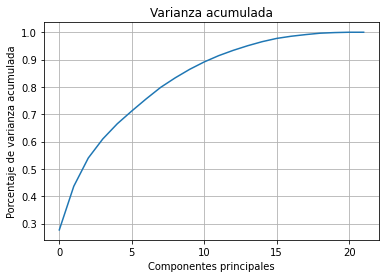

In [15]:
# aca realizamos una curva de varianza explicada del PCA
pca_varianza = PCA(n_components=x.shape[1]).fit(StandardScaler().fit_transform(x))
plt.plot(np.cumsum(pca_varianza.explained_variance_/np.sum(pca_varianza.explained_variance_)))
plt.title('Varianza acumulada')
plt.xlabel('Componentes principales')
plt.ylabel('Porcentaje de varianza acumulada')
plt.grid()

In [ ]:
#@title Pregunta Abierta
#@markdown  ¿Como se relaciona el mejor número de componentes encontrado en los experimentos con la curva de varianza explicada? Explicar con base a los resultados, la grafica y la teoria
respuesta_4 = 'El mejor numero de componentes encontrados en los experimentos se relaciona con la curva de varianza en el sentido en que en el intervalo [10,15) (o hasta 20) podemos apreciar un porcentaje mejor de variabilidad, \xF3sea del 90% para arriba' #@param {type:"string"}

## Ejercicio 3: Entrenamiento usando Discriminante de Fisher para extracción

En este ejercicio vamos a aplicar PCA para realizar la extracción de caracteristicas. Para ello tener en cuenta:

1. Vamos a usar el modulo [LinearDiscriminantAnalysis-LDA de sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html). El cual ya se encuentra importado (se pueda acceder a el como `LinearDiscriminantAnalysis(....)`)
2. ¿También se estandarizar los datos?
3. Usar 5 particiones en la metodologia de validación
3. Usar la exactitud/accuracy como medida de error del modulo [metrics de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics)
4. Vamos a calcular el costo computacional de aplicar la LDA.
5. Recordar que LDA se debe "ajustar" con el conjunto de entrenamiento. Pero la transformación se debe hacer para las particiones de entrenamiento y test.

In [ ]:
#@title Pregunta Abierta
#@markdown Explicar en sus palabras la principal ventaja que tiene LDA sobre PCA para resolver problemas de clasificación.
respuesta_5 = 'Explicado en nuestras propias palabras, la ventaja que tiene LDA sobre PCA es que el primero pretende maximizar el hecho de la separaci\xF3n entre las clases, buscando un subespacio de caracter\xEDsticas, con distribuciones iguales y covarianzas iguales, mientras que el segundo pretende buscar las caracter\xEDsticas con mayor variaci\xF3n; muy probablemente el primero requiera mas procesamiento computacional' #@param {type:"string"}

In [20]:
#ejercicio de código
def entrenamiento_lda_ext_caracteristicas(n_comp, X, Y):
    """
    Esta función realiza la reducción de la dimensionalidad sobre el conjunto de
    datos de entrenamiento, de acuerdo con las particiones especificadas usando PCA

    Parámetros:
    n_comp, int, Número de componentes para reducción
    n_sets,int, Número de particiones
    X: numpy Array de características
    Y: numpy Array  Vector de etiquetas

    Retorna: 
    ErrorValidacion: El valor medio de errores
    IC_Validacion: Intervalo de confianza
    T_ejec:  El  valor medio del tiempo de ejecución
    """
   

    #Implemetamos la metodología de validación 
    Errores = np.ones(5)
    times = np.ones(5)
    j = 0
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):  
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        # ¿es necesario estandarizacion de datos?
        ...
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # dejar el nombre del objeto igual (lda)
        lda = LinearDiscriminantAnalysis(n_components=n_comp)
        # para calcular costo computacional
        tiempo_i = time.time()
        # es recomendable usar el metodo que ajusta y transforma
        X_train_lda = lda.fit_transform(X_train, y_train)
        # aca solo usar el metodo de transformar (ya que en el anterior el pca se ajusto)
        X_test_lda = lda.transform(X_test)
        # entrenar el modelo usando las caractieristicas transformadas por PCA
        clf = SVC(kernel="linear", C=1)
        clf.fit(X=X_train_lda, y=y_train)
        tiempo_o = time.time()-tiempo_i
        Errores[j] = accuracy_score(y_true=y_test, y_pred=clf.predict(X_test_lda))
        times[j] = tiempo_o
        j+=1


    return np.mean(Errores), np.std(Errores), np.mean(times)


In [21]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio3", entrenamiento_lda_ext_caracteristicas)

TEST EXITOSO!


## Ejercicio 4 : Experimentar con Discriminante de Fisher

Usando las anteriores funciones vamos a realizar experimentos para evaluar la efectividad de PCA, para ello:

1. Utilizar una metodología cross-validation con 5 particiones.
2. Usar como parametros para los experimentos el número de características a extraer
3. Usar la función `entrenamiento_pca_ext_caracteristicas` para realizar la extración de características.
3. Vamos a retornar un DataFrame con las siguientes columnas:
    - CON_SEL (indicando si se uso selección de caracteristicas)
    - NUM_VAR (número de selección de caracteristicas)
    - ERROR_VALIDACION
    - IC_STD_VALIDACION
    - T_EJECUCION: tiempo de ejecucción
4. En la primera fila del dataframe vamos a incluir la evaluación del modelo SVM sin selección de características (usando la función creada en el primer ejercicio). 

In [24]:
#ejercicio de código
def experimentar_LDA(n_feats, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: DESCRIPCION, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: DESCRIPCION, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    df = pd.DataFrame()
    idx = 0
    split_number = 5
    #Sin selección de características
    error,ic_error,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
    df.loc[idx,'CON_SEL'] = 'NO'
    df.loc[idx,'NUM_VAR'] = X.shape[1] # se usan todas las caracteristicas
    df.loc[idx,'ERROR_VALIDACION'] = error
    df.loc[idx,'IC_STD_VALIDACION'] = ic_error
    df.loc[idx,'T_EJECUCION'] = t_ex
    idx+=1
    print("termina experimento sin selección")
    #Con selección de características
    
    for f in n_feats:
        #Implemetamos la metodología de validación 
        error, ic_error, t_ex = entrenamiento_lda_ext_caracteristicas(n_comp=f, X=x,Y=y)
        df.loc[idx,'CON_SEL'] = 'SI'
        df.loc[idx,'NUM_VAR'] = X.shape[1]
        df.loc[idx,'ERROR_VALIDACION'] = error
        df.loc[idx, 'IC_STD_VALIDACION'] = ic_error
        df.loc[idx, 'T_EJECUCION'] = t_ex
        idx+=1
    return df


In [25]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio4", experimentar_LDA)

termina experimento sin selección
TEST EXITOSO!


In [ ]:
experimentar_LDA(n_feats=[1,2], X= x, Y = y)

In [ ]:
#@title Pregunta Abierta
#@markdown  ¿que diferencias existen entre los métodos de selección de características y los métodos de extracción de características vistos en la anterior sesión? Explicar
respuesta_6 = 'Las diferencias b\xE1sicas que existen entre los m\xE9todos de selecci\xF3n de caracter\xEDsticas y los m\xE9todos de extracci\xF3n de caracter\xEDsticas vistos en la anterior sesi\xF3n, es que las primeras eligen subconjuntos de datos y las segundas crean un conjunto diferente.' #@param {type:"string"}

In [26]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia e archivo al formulario ¡buen trabajo!


In [ ]:
#@title Integrantes
codigo_integrante_1 ='1037652924' #@param {type:"string"}
codigo_integrante_2 = '1061805868'  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [ ]:
GRADER.grade()